<img align="right" src="../../additional_data/banner_siegel.png" style="width:1100px;">

# Parallel processing with Dask

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Products used**: 
* **Prerequisites**:  Users of this notebook should have a basic understanding of:
    * How to run a [Jupyter notebook](01_jupyter_introduction.ipynb)
    * The basic structure of the eo2cube [satellite datasets](02_eo2cube.ipynb)
    * How to browse through the available [products and measurements](03_products_and_measurements.ipynb) of the eo2cube datacube 
    * How to [load data from the eo2cube datacube](04_loading_data_and_basic_xarray.ipynb)
    * How the data is stored and structured in a [xarray](05_advanced_xarray.ipynb)
    * How to [visualize the data](06_plotting.ipynb)
    * How to do a [basic analysis of remote sensing data](07_basic_analysis.ipynb) in the eo2cube environment

## What is Dask?
[Dask](https://dask.org/) is a library for parallel computing. It can be used to scale Pandas, NumPy, and Scikit-Learn workflows. Originally, datasets created with those libraries can only be scaled on a single machine. Dask internally uses the structures of Pandas, Numpy and Scikit-Learn. Thus, if you are familiar with those libraries, it will be easy to transform your "old" code in a new, scalable dask-version of it. <br>
In this notebook, we will mainly work with [daskArray](https://docs.dask.org/en/latest/array.html) which is the dask-equivalent to NumPy ndarray.

## Package import and datacube connection

First of all you start with importing all the packages that are needed for our analysis.<br>
Most of the packages have already been introduced in the previous notebooks. The newly introduced package here is Dask.

In [102]:
import datacube

# dask
import dask
from dask.distributed import Client

# plotting
import graphviz

# images
import matplotlib.pyplot as plt
# from DEAPlotting import display_map, rgb

connecting to the datacube

In [103]:
dc = datacube.Datacube(app = '08_parallel_processing_with_dask', config = '/home/datacube/.datacube.conf')

## Dask Schedulers
### (Single machine scheduler vs. Distributed scheduler)
Dask can be used to scale computations across multiple computers (cluster). <br>
But it also can be used for parallel computing on a single computer. This enables computations that normally would have been too demanding for the used machine.<br>
For the following analysis we are using the distributed scheduler since we are working on a datacube.<br>

(https://docs.dask.org/en/latest/setup.html) 

## Setting up Dask.distributed

To start the Dask Client, we use the Dask-plugin within the Phenocube.
To use it, just click on the orange Dask symbol on the left side of the window. Then click on the "+ New" Button. A new LocalCluster is created. <br> By clicking on the "Scale" button, the Client can be scaled (i.e. reducing the number of workers). <br>
Now, just drag and drop the Cluster into this code.

In [101]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46779")
client

<Client: 'tcp://127.0.0.1:46779' processes=2 threads=10, memory=47.54 GB>

## Loading the data using dask
In the following, the data is loaded.
As you remeber from the previous notebooks a "normal" command for loading data looks somewhat like this: <br>
`
ds = dc.load(product = "s2_l2a_bavaria",
             measurements = ["blue", "green","red", "red_edge2", "nir", "narrow_nir"],
             longitude = [12.493, 12.509],
             latitude = [47.861, 47.868],
             time = ("2020-04-01", "2021-03-31"))
`
<br>
For loading data with dask, you just add the "dask_chunks"-parameter. <br>
This looks like this:

In [106]:
# Load Data
ds = dc.load(product = "s2_l2a_bavaria",
             measurements = ["blue", "green","red", "red_edge2", "nir", "narrow_nir"],
             longitude = [12.493, 12.509],
             latitude = [47.861, 47.868],
             time = ("2020-04-01", "2020-04-30"),
             dask_chunks={"time": 1, "x": 50, "y": 50})

To understand what we have done here, lets first look at the dataset we loaded.

In [107]:
ds

<xarray.Dataset>
Dimensions:      (time: 30, x: 124, y: 84)
Coordinates:
  * time         (time) datetime64[ns] 2020-04-01T10:27:13 ... 2020-04-30T10:...
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
Data variables:
    blue         (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red_edge2    (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

You see that the xarray.Dataset consists of multiple [dask.array](https://docs.dask.org/en/latest/array.html) objects but we cannot see any values inside our data. <br>
This type of data is called "lazy data" as it is not loaded properly but in a "lazy" way without data values.

## Dask Chunks
The parameter that was added to the dc.load() command is called "dask_chunks". It defines in how many parts our original dataset will be splitted. As described in the previous notebooks, normally the dc.load() command produces a xarray dataset consisting of integer values.<br>
In our case, the dataset is split into smaller chunks. Since the data we are interested in is three dimensional, we also need to provide three dimensions for subdividing the data. <br>
The provided values have been {"time": 1, "x": 50, "y": 50}. Accordingly, the chunksize of the dask.arrays is (1,50,50). <br>
<br>
In the following we will visualize the lazy-loaded data for the red band to get an even better feeling about our type of data.


In [108]:
# visualizing the dask chunks
ds.red.data

dask.array<dc_load_red, shape=(30, 84, 124), dtype=int16, chunksize=(1, 50, 50), chunktype=numpy.ndarray>

Here, the red band of our lazy dataset is shown. We see that our data has been devided into a total of 180 chunks, each having a size of 1 timestep, 50 pixels in x-direction, and 50 pixels in y-direction. <br>
Looking at the memory size of the chunks compared to the complete array, the motivation for using dask becomes clear. Especially when working with large amounts of data, splitting the data into smaller chunks enables computations that would crash the Phenocube environment when calculated over the complete array at once.

## Lazy operations

When working with large amounts of data, it makes sense to postpone loading the data as far back as possible. To do so, we can perform operations on lazy data directly, without loading its values. <br>
When we want to do a computation on lazy data, it makes sense to chain operations together and to just calculate the result right at the end (with the compute() function). 
One example for that is the following calculation of NDVI values on the lazy data.

In [109]:
band_diff = ds.nir - ds.red
band_sum = ds.nir + ds.red

ds["ndvi"] = band_diff / band_sum
ds

<xarray.Dataset>
Dimensions:      (time: 30, x: 124, y: 84)
Coordinates:
  * time         (time) datetime64[ns] 2020-04-01T10:27:13 ... 2020-04-30T10:...
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
Data variables:
    blue         (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red_edge2    (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

we now calculated the NDVI based on lazy-loaded data. Since we have not used the load() function, the ndvi itself is a lazy-loaded dask.array as well.

Another advantage of dask is its ability to only perform necessary operations within a process. (Here there is still some information missing!!)

The `visualize()`function produces a graph which shows the tasks that dask needs to perform to excecute the operations.<br>
If the graph is too large, an error occurs. In this case, just look at you working folder for a .png file. This should contain your produced graph. <br>
If the graph opens within the notebook, doubleclicking on it will enlarge it.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.546764 to fit


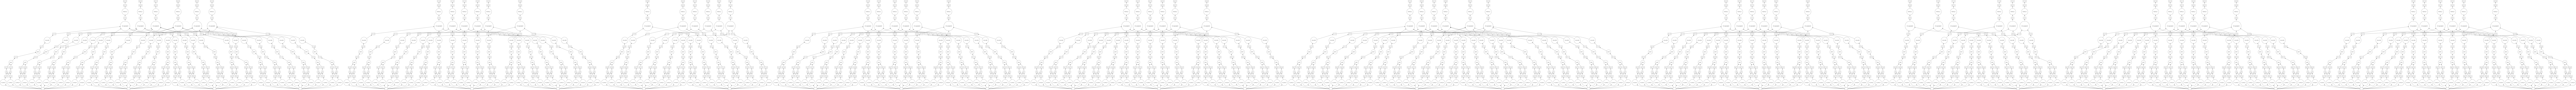

In [110]:
ds_group = ds.resample(time="3D").mean(dim="time")
ds_group.ndvi.data.visualize()

## Previously performed calculations
In the previous notebook you did some basic analysis. Now, this analysis will be repeated but using dask. Like already mentioned, the code will not differ a lot, since dask is build on numpy. But you will see a difference in performance of the analysis.

following functions from:
https://github.com/Shirobakaidou/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/07_ts_tesselCap.ipynb

In [111]:
# Group by month, Mean
ds_mmean = ds.groupby('time.month').mean(dim='time')
print(ds_mmean)

<xarray.Dataset>
Dimensions:      (month: 1, x: 124, y: 84)
Coordinates:
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
  * month        (month) int64 4
Data variables:
    blue         (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red_edge2    (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ndvi         (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>


In [112]:
# Tesseled Cap Wetness
wet = 0.1509*ds_mmean.blue + 0.1973*ds_mmean.green + 0.3279*ds_mmean.red + 0.3406*ds_mmean.nir-0.711211-0.457212
# Tesseled Cap Green Vegetation
gvi = -0.2848*ds_mmean.blue-0.2435*ds_mmean.green-0.5436*ds_mmean.red + 0.7243*ds_mmean.nir + 0.084011-0.180012
# Tesseled Cap Soil Brightness
sbi = 0.332*ds_mmean.green + 0.603*ds_mmean.red + 0.675*ds_mmean.red_edge2 + 0.262*ds_mmean.narrow_nir

In [113]:
ds_mmean['wet']=wet
ds_mmean['gvi']=gvi
ds_mmean['sbi']=sbi
print(ds_mmean)

<xarray.Dataset>
Dimensions:      (month: 1, x: 124, y: 84)
Coordinates:
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
  * month        (month) int64 4
Data variables:
    blue         (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red_edge2    (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ndvi         (month, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    wet          (month, y, x) float64 dask.array<chunksize=(1, 50, 50), 

In [ ]:
#ds_mmean.red.data

In [119]:
ds_mmean.gvi.max().compute()

<xarray.DataArray 'gvi' ()>
array(575.862079)
Coordinates:
    spatial_ref  int32 25832

## Delay function

may be useful when working with more complex functions that are not supported by dask???<br>
e.g. filter functions...

## Loading lazy data

Lazy Dask arrays do not evaluate (e.g. contain actual values) until their calculation is initiated. The compute()-functions triggers such an evaluation.<br>
It is important to note that `compute()`writes its results into memory. So only use it if the results will fit in it. If they are too large, it is possible to write them to disk directly. 
For dask Arrays the `to_hdf5()`command can be used (`my_dask_array.to_hdf5("myfile.hdf5")`) to do so. <br>
Running the compute() function might take some time depending on the size of your `DataArray` or `Dataset`.

In [100]:
ds_loaded = ds.load()
ds_loaded

ds_comp = ds.compute()
ds_comp
# missing:
# compute() function

<xarray.Dataset>
Dimensions:      (time: 30, x: 124, y: 84)
Coordinates:
  * time         (time) datetime64[ns] 2020-04-01T10:27:13 ... 2020-04-30T10:...
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
Data variables:
    blue         (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    green        (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    red          (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    red_edge2    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nir          (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    narrow_nir   (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    ndvi         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

As you see, the values of the Data variables now have changed from `dask.array`to actual `int16`values. This data can now for example be plotted. This is done in the following.

<xarray.DataArray 'red' (y: 84, x: 124)>
array([[ 143,  145,  152, ...,  171,  174,  181],
       [ 146,  141,  148, ...,  164,  170,  178],
       [ 148,  146,  149, ...,  175,  170,  187],
       ...,
       [1168, 1074,  880, ...,  498,  503,  503],
       [1212,  993,  821, ...,  529,  550,  545],
       [1234,  995,  822, ...,  583,  583,  566]], dtype=int16)
Coordinates:
    time         datetime64[ns] 2020-04-03T10:17:21
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
Attributes:
    units:         reflectance
    nodata:        0
    crs:           EPSG:25832
    grid_mapping:  spatial_ref


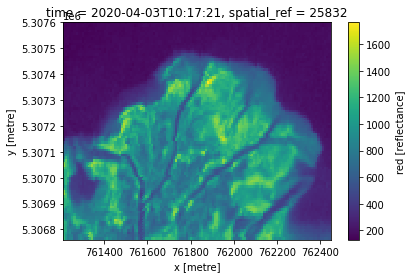

In [79]:
# selecting one timestep
timestep = ds_loaded.red.isel(time=2)
print(timestep)
timestep.plot()


## Further Information
For further information about Dask, pleas have a look at the [Dask webpage](https://docs.dask.org/en/latest/).

## Recommended next steps

To continue with the beginner's guide, the following notebooks are designed to be worked through in the following order:

1. [Jupyter Notebooks](01_jupyter_introduction.ipynb)
2. [eo2cube](02_eo2cube.ipynb)
3. [Products and Measurements](03_products_and_measurements.ipynb)
4. [Loading data and introduction to xarrays](04_loading_data_and_basic_xarray.ipynb)
5. [Advanced xarrays operations](05_advanced_xarray.ipynb)
6. [Plotting data](06_plotting.ipynb)
7. [Basic analysis of remote sensing data](07_basic_analysis.ipynb)
8. **Parallel processing with Dask (this notebook)**

***

## Additional information

<font size="2">This notebook for the usage in the Open Data Cube entities of the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/), is adapted from [Geoscience Australia](https://github.com/GeoscienceAustralia/dea-notebooks), published using the Apache License, Version 2.0. Thanks!</font>

https://doi.org/10.26186/145234 <br>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.


**Contact:** If you would like to report an issue with this notebook, you can file one on [Github](https://github.com).

**Last modified:** February 2021